In [5]:
import heapq
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Callable, Optional
from noise import snoise2

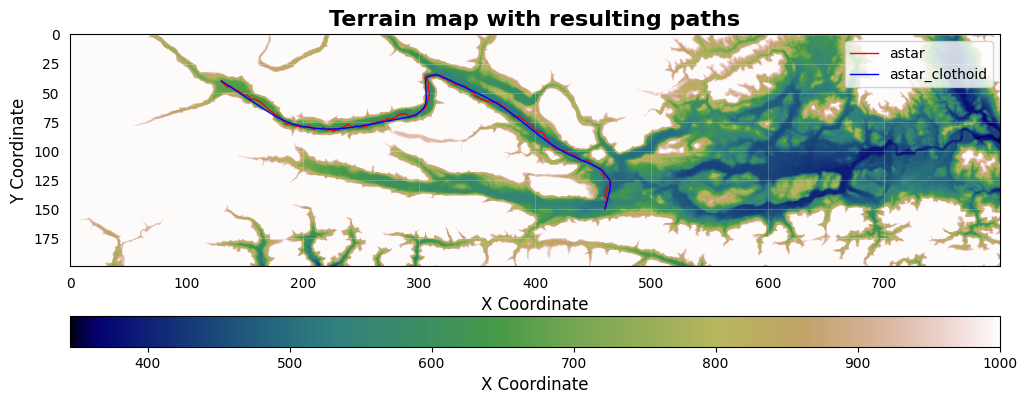

In [13]:
from a_star import A_star
import numpy as np
import matplotlib.pyplot as plt
from clothoids.create_clothoids import clothoids_from_control_points

def plot_result_path(path1, path2, heightmap):
    # Create a new figure with a specific size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the heightmap
    im = ax.imshow(heightmap, cmap='gist_earth', interpolation='bilinear', vmax=1000)
    # ax.plot(path[:,1], path[:,0], linestyle='-', color='white', linewidth=2,
    #     markersize=6, markeredgecolor='darkblue', markerfacecolor='lightblue',
    #     label=f'{self.basepath_approach} control points path')

    plt.plot(path1[:, 1], path1[:, 0], linestyle='-', color='red', label="astar", linewidth=1)
    plt.plot(path2[:, 1], path2[:, 0], linestyle='-', color='blue', label="astar_clothoid", linewidth=1)

    # Set title and labels
    ax.set_title('Terrain map with resulting paths', fontsize=16, fontweight='bold')
    ax.set_xlabel('X Coordinate', fontsize=12)
    ax.set_ylabel('Y Coordinate', fontsize=12)

    # Remove ticks but keep labels
    ax.tick_params(axis='both', which='both', bottom=False, top=False,
                    labelbottom=True, left=False, right=False, labelleft=True)

    # Add a grid for better readability
    ax.grid(color='white', linestyle='-', linewidth=0.5, alpha=0.3)

    # Add a horizontal colorbar below the plot
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', aspect=30, pad=0.08)
    cbar.set_label('X Coordinate', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    # Add legend
    ax.legend(loc='upper right', fontsize=10)


def point_line_distance(point: list, start: list, end: list) -> float:
    """
    Calculates the perpendicular distance between a point and a line segment in 2D space.

    Args:
        point: A list representing the coordinates of the point (x, y).
        start: A list representing the coordinates of the starting point of the line segment (x1, y1).
        end: A list representing the coordinates of the ending point of the line segment (x2, y2).

    Returns:
        The perpendicular distance between the point and the line segment.
    """
    if start == end:
        return np.sqrt((point[0] - start[0])**2 + (point[1] - start[1])**2)
    
    n = np.abs((end[0] - start[0]) * (start[1] - point[1]) - (start[0] - point[0]) * (end[1] - start[1]))
    d = np.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)
    return n / d

def douglas_peucker(points: list, epsilon: float):
    """
    Implements the Douglas-Peucker algorithm for line simplification.

    Args:
        points: A list of points (x, y) representing the original line.
        epsilon: The maximum distance tolerance for simplification.

    Returns:
        A simplified list of points representing the line.
    """
    dmax = 0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d

    if dmax > epsilon:
        results = douglas_peucker(points[:index+1], epsilon) + douglas_peucker(points[index:], epsilon)[1:]
    else:
        results = [points[0], points[-1]]

    return results

astar = A_star()
heightmap = np.load("./heightmaps/austria_2000_8000_heightmap_wo_norm.npy")
heightmap = astar.downsample_heightmap(heightmap, 200, 800)

start = (40, 130)
goal = (150, 460)

path1 = astar.astar_heightmap(heightmap, start, goal, astar.euclidean_distance, astar.height_difference_cost)
simplified_points = douglas_peucker(path1, epsilon=5)
s_np = np.array(simplified_points)

c_np = clothoids_from_control_points(s_np, tau=0.4)      

plot_result_path(np.array(path1),c_np, heightmap)

In [14]:
def plot_heightmap_and_paths(
    heightmap_data: np.ndarray,
    paths: List[List[Tuple[int, int]]],
    start: Optional[Tuple[int, int]] = None,
    finish: Optional[Tuple[int, int]] = None,
    path_labels: Optional[List[str]] = None,
    path_colors: Optional[List[str]] = None
):
    plt.figure(figsize=(12, 8))
    
    # Plot the heightmap
    im = plt.imshow(heightmap_data, cmap='gist_earth')
    plt.colorbar(label='Elevation', orientation='horizontal')
    
    # Plot start point
    if start:
        plt.plot(start[1], start[0], 'go', markersize=10, label='Start')
    
    # Plot finish point
    if finish:
        plt.plot(finish[1], finish[0], 'ro', markersize=10, label='Finish')
    
    # Default colors if not provided
    if path_colors is None:
        path_colors = plt.cm.rainbow(np.linspace(0, 1, len(paths)))
    
    # Default labels if not provided
    if path_labels is None:
        path_labels = [f'Path {i+1}' for i in range(len(paths))]
    
    # Plot paths
    for i, path in enumerate(paths):
        if path:
            path_y, path_x = zip(*path)
            plt.plot(path_x, path_y, linestyle='-', color=path_colors[i], linewidth=2, label=path_labels[i])
    
    plt.title('Heightmap with Multiple Paths')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

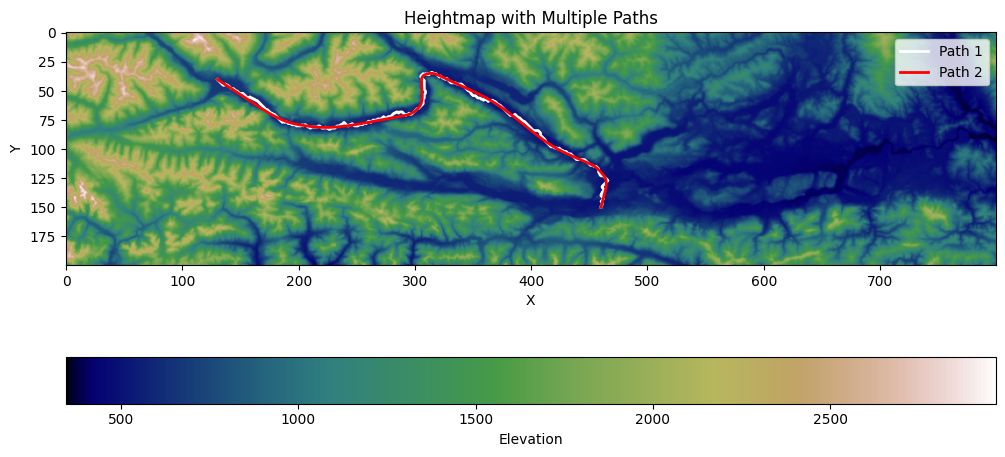

In [15]:
plot_heightmap_and_paths(heightmap, [path1,c_np.tolist()], path_colors=['white', 'red'])